In [10]:
from corpus import Corpus
import numpy as np
import matplotlib.pyplot as plt

In [2]:
corpus = Corpus.from_file('data/train.json')

In [3]:
corpus.build_vectors()

In [4]:
corpus.build_np_vecs()

# new KNN

In [8]:
from k_eval import KNN_cosine, KNN_euclid

In [21]:
limit = None
knn_cosine = KNN_cosine(corpus, limit=limit)
knn_euclid = KNN_euclid(corpus, limit=limit)
knns = {'cosine': knn_cosine, 'euclid': knn_euclid}

In [22]:
import time
log = dict()
success = dict()
for name, knn in knns.items():
    knn.set_valid('data/validation.json')
    for k in [1, 3, 5]:
        knn.parameters['k'] = k
        t0 = time.time()
        log[(name, k)] = knn.evaluate()
        success[(name, k)] = sum(log[(name, k)]) / 3000
        t1 = time.time()
        total = t1 - t0
        print(f"{name}, {k}: {success[(name, k)]}.\t limit={limit}, time={total}")

cosine, 1: 0.847.	 limit=None, time=155.67932105064392
cosine, 3: 0.8613333333333333.	 limit=None, time=155.6478750705719
cosine, 5: 0.8686666666666667.	 limit=None, time=151.71014213562012
euclid, 1: 0.742.	 limit=None, time=160.54853987693787
euclid, 3: 0.7323333333333333.	 limit=None, time=160.8194601535797
euclid, 5: 0.725.	 limit=None, time=274.2830789089203


In [23]:
best_k = dict()
for name, knn in knns.items():
    best_k[name] = max([1, 3, 5], key=lambda k: success[(name, k)])
best_k

{'cosine': 5, 'euclid': 1}

# Naive 

In [4]:
corpus.build_naive()

In [6]:
from k_eval import Naive_classifier
bayes = Naive_classifier(corpus)

In [8]:
bayes.set_valid('data/validation.json')

In [26]:
alphas_being_tested = 10**np.linspace(-5, 2, 20)
import time
t0 = time.time()
score = []
log = []
for alpha in alphas_being_tested:
    bayes.parameters['alpha'] = alpha
    bayes.evaluate()
    log.append(bayes.log)
    score.append(sum(bayes.log) / 3000)
    print(f"alpha: {alpha}, score: {score[-1]}")
    
t1 = time.time()

total = t1-t0
total

alpha: 1e-05, score: 0.8763333333333333
alpha: 2.3357214690901213e-05, score: 0.8783333333333333
alpha: 5.4555947811685143e-05, score: 0.881
alpha: 0.00012742749857031334, score: 0.8823333333333333
alpha: 0.00029763514416313193, score: 0.8833333333333333
alpha: 0.0006951927961775605, score: 0.8873333333333333
alpha: 0.001623776739188721, score: 0.8886666666666667
alpha: 0.00379269019073225, score: 0.8903333333333333
alpha: 0.008858667904100823, score: 0.893
alpha: 0.02069138081114788, score: 0.895
alpha: 0.04832930238571752, score: 0.8953333333333333
alpha: 0.11288378916846883, score: 0.8956666666666667
alpha: 0.26366508987303555, score: 0.897
alpha: 0.6158482110660255, score: 0.8966666666666666
alpha: 1.438449888287663, score: 0.8956666666666667
alpha: 3.359818286283781, score: 0.8903333333333333
alpha: 7.847599703514607, score: 0.8833333333333333
alpha: 18.32980710832434, score: 0.876
alpha: 42.81332398719387, score: 0.8646666666666667
alpha: 100.0, score: 0.8493333333333334


24.585701942443848

In [27]:
scorere

[0.8763333333333333,
 0.8783333333333333,
 0.881,
 0.8823333333333333,
 0.8833333333333333,
 0.8873333333333333,
 0.8886666666666667,
 0.8903333333333333,
 0.893,
 0.895,
 0.8953333333333333,
 0.8956666666666667,
 0.897,
 0.8966666666666666,
 0.8956666666666667,
 0.8903333333333333,
 0.8833333333333333,
 0.876,
 0.8646666666666667,
 0.8493333333333334]

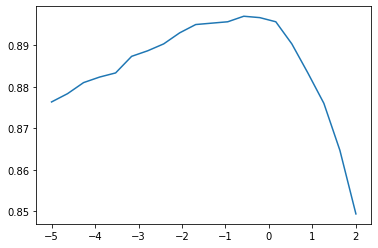

(12, 0.26366508987303555, -0.5789473684210531)

In [32]:
score = np.array(score)
plt.plot(np.log10(alphas_being_tested), score)
plt.show()
best_index = np.argmax(score)
best_alpha = alphas_being_tested[best_index]
(
    best_index,
    best_alpha,
    np.log10(best_alpha),
)

# nltk

In [5]:
from corpus import Corpus
import numpy as np
import matplotlib.pyplot as plt

In [13]:
from k_eval import Naive_classifier, KNN_cosine
from helper import k_stemm, k_lemm, remove_stopwords
import time

In [22]:
models = {
    'knn cosine 5': KNN_cosine(corpus=None, k=5),
    'naive bayes': Naive_classifier(corpus=None, alpha=0.3),
}
funcs_to_test = {
    'Nothing': None,
    'stopword removal': remove_stopwords,
    'lemmatizing': k_lemm,
    'stemming': k_stemm,
}
for model_name, model in models.items():
    for func_name, func in funcs_to_test.items():
        t0 = time.time()
        print(f"starting building corpus for {model_name}, {func_name}")
        pipeline = [func] if func is not None else []
        corpus = Corpus.from_file('data/train.json', pipeline=pipeline)
        model.corpus = corpus
        model.corpus_limit = len(corpus.docs)
        model.pre_build()
        model.set_valid('data/validation.json')
        print(f"starting {model_name}, {func_name}")
        model.evaluate()
        print(f"Results: {sum(model.log)/3000}% (exact number is {sum(model.log)})")
        t1 = time.time()
        total_time = t1 - t0
        print(f"total time: {total_time}s")
        print()

starting building corpus for knn cosine 5, Nothing
starting knn cosine 5, Nothing
Results: 0.8686666666666667% (exact number is 2606)
total time: 267.15364503860474s

starting building corpus for knn cosine 5, stopword removal
starting knn cosine 5, stopword removal
Results: 0.8673333333333333% (exact number is 2602)
total time: 355.4317078590393s

starting building corpus for knn cosine 5, lemmatizing
starting knn cosine 5, lemmatizing
Results: 0.8706666666666667% (exact number is 2612)
total time: 274.8412969112396s

starting building corpus for knn cosine 5, stemming
starting knn cosine 5, stemming
Results: 0.8693333333333333% (exact number is 2608)
total time: 195.79374599456787s

starting building corpus for naive bayes, Nothing
starting naive bayes, Nothing
Results: 0.8976666666666666% (exact number is 2693)
total time: 5.718931198120117s

starting building corpus for naive bayes, stopword removal
starting naive bayes, stopword removal
Results: 0.9006666666666666% (exact number i